In [12]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
import scipy.stats 
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def loaddict():
    res = {}
    fin = open("/Users/jiayao/Work/BrainDisorders/src/cds.dict", 'rb')
    for l in fin:
        llist = l.strip().split()
        gene, exon_s, cds_s, cds_e = llist[0], int(llist[1])-1, int(llist[2])-1, int(llist[3])
        if gene not in res:
            res[gene] = {}
        if exon_s not in res[gene]:
            res[gene][exon_s] = (cds_s, cds_e)
    return res
cds_dict = loaddict()
def addcds(row, cds_dict):
    s = row["start"]
    gene = row["gene_symbol"]
    if gene not in cds_dict:
        return row["exon length"]
    if s in cds_dict[gene]:
        cds_s, cds_e = cds_dict[gene][s]
        return cds_e - cds_s
    else:
        return row["exon length"]

In [10]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)

strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta.head(5)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,66
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99


In [14]:
expdict_gene = ins.LoadGeneSetDataFromFil2("./data/qn.ProbandLGD_PRE.Regionsgt20.GeneLog2Exp.csv")
expdict_exon = ins.LoadGeneSetDataFromFil("./data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")

In [42]:
gene_bias_dict = {}
for gene, exps in expdict_gene.items():
    tmp = []
    #print exps
    for stage in ins.Stages:
        tmp.append(np.mean(exps[stage]))
    #print len(tmp)
    pre, post = np.mean(tmp[:6]), np.mean(tmp[6:])
    try:
        bias = pre/post
    except:
        bias = 0
    gene_bias_dict[gene] = (pre, post, bias)

/Users/jiayao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


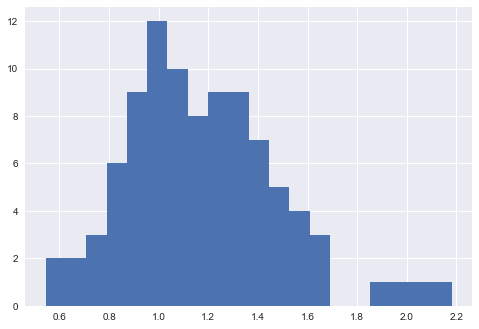

In [43]:
dat = [x[2] for x in gene_bias_dict.values()]
dat = np.array(dat)
dat = dat[~np.isnan(dat)]
plt.hist(dat, bins=20)
plt.show()

In [44]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))

SSCLGD_predicted = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SSCLGD_predicted.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(SSCLGD_predicted.genes), len(SSCLGD_predicted.TargetedExon),len(SSCLGD_predicted.UntargetedExon)

(94, 15)
94 118 2151


In [45]:
bp_exon_row_meta_with_gene.head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,NVIQ70,VIQ70,Gender,Func,Vars,GeneHited,Last
0,1249,1086943,ENSG00000005108,THSD7A,221981,11410063,11415505,5442,82,,,,,,T,F
1,1250,1086943,ENSG00000005108,THSD7A,221981,11416196,11416284,88,88,,,,,,T,F
2,1251,1086943,ENSG00000005108,THSD7A,221981,11418696,11418907,211,211,,,,,,T,F
3,1252,1086943,ENSG00000005108,THSD7A,221981,11419256,11419382,126,83,,,,,,T,F
4,1253,1086943,ENSG00000005108,THSD7A,221981,11422147,11422243,96,96,,,,,,T,F


In [108]:
def GetExonExp(gene, ExonID):
    # expdict[gene][ExonID]
    tmp = []
    for stage in ins.Stages:
        tmp.append(np.mean(expdict[gene][ExonID][stage]))
    pre, post = np.mean(tmp[:6]), np.mean(tmp[6:])
    try:
        bias = pre/post
    except:
        bias = 0
    return pre, post, bias 

class EXON:
    def __init__(self, ID, hitted, genepre, genepost, genebias, exonpre, exonpost, exonbias, exonCDS):
        self.ID = ID
        self.hitted = hitted
        self.genepre = genepre
        self.genepost = genepost
        self.genebias = genebias
        self.exonpre = exonpre
        self.exonpost = exonpost
        self.exonbias = exonbias
        if self.genebias == 0:
            self.relbias = 0
        else: 
            try:
                self.relbias = self.exonbias / self.genebias
            except:
                self.relbias = 0
        if math.isnan(self.relbias):
            self.relbias = 0
        if self.relbias > 10:
            self.relbias = 10
        self.CDSLength = exonCDS
        
ExonPool = []
for gene in SSCLGD_predicted.genes:
    gegnepre, genepost, genebias = gene_bias_dict[gene]
    for exonID in SSCLGD_predicted.Genes[gene].TargetedExons:
        exonpre, exonpost, exonbias = GetExonExp(gene, exonID)
        exonCDS = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"]==exonID]["cds length"].values[0]
        Exon = EXON(exonID, True, gegnepre, genepost, genebias, exonpre, exonpost, exonbias, exonCDS)
        ExonPool.append(Exon)
    for exonID in SSCLGD_predicted.Genes[gene].UntargetedExons:
        exonpre, exonpost, exonbias = GetExonExp(gene, exonID)
        exonCDS = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["row_num"]==exonID]["cds length"].values[0]
        Exon = EXON(exonID, False, gegnepre, genepost, genebias, exonpre, exonpost, exonbias, exonCDS)
        ExonPool.append(Exon)

/Users/jiayao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


In [109]:
ExonPool.sort(key=lambda x: x.relbias)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
8.08223493643 0.0


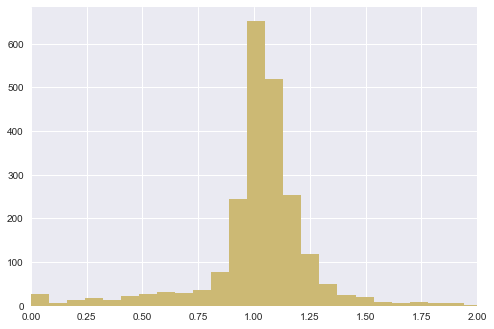

In [110]:
dat = [x.relbias for x in ExonPool if x.relbias < 10]
print dat[:10]
dat = np.array(dat)
dat = dat[~np.isnan(dat)]
print max(dat), min(dat)
plt.hist(dat, bins=100)
plt.xlim(0,2)
plt.show()

In [111]:
parts = []
step = len(ExonPool)/4
print step
ExonPool = sorted(ExonPool, key=lambda x: x.relbias)
for i in range(3):
    print i*step,(i+1)*step
    parts.append(ExonPool[i*step:(i+1)*step])
print 3*step, len(ExonPool)
parts.append(ExonPool[3*step:])
for i in range(4):
    #print i, min([x.relbias for x in parts[i]]), max([x.relbias for x in parts[i]])
    print i, parts[i][0].relbias, parts[i][-1].relbias#, min([x.relbias for x in parts[i]]), max([x.relbias for x in parts[i]])

567
0 567
567 1134
1134 1701
1701 2269
0 0 0.973198929336
1 0.973635176554 1.04427429984
2 1.04427559356 1.12797854071
3 1.12807971854 10


In [113]:
for i in range(len(ExonPool)-1):
    if ExonPool[i].relbias > ExonPool[i+1].relbias:
        print i

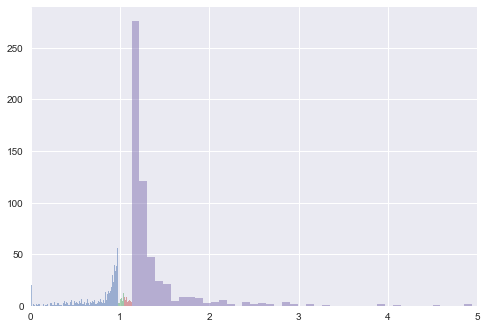

In [116]:
plt.hist([x.relbias for x in parts[0]], bins=100, alpha=0.5)
plt.hist([x.relbias for x in parts[1]], bins=100, alpha=0.5)
plt.hist([x.relbias for x in parts[2]], bins=100, alpha=0.5)
plt.hist([x.relbias for x in parts[3]], bins=100, alpha=0.5)
plt.xlim(0,5)
plt.show()

In [117]:
TotalCDS = sum([x.CDSLength for x in ExonPool])
print TotalCDS

509255


In [ ]:
for i in range(3):
    P = sum([x.CDSLength for x in parts[i]])/TotalCDS
    print scipy.stats.binom_test()